import all usefull tool

In [1]:
%pylab inline

import pandas as pd
import numpy as np
import itertools
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# Read in Datasets

## Load Dataset 1 - fake_or_real_news.csv
Read in File fake_or_real_news.csv

In [2]:
df = pd.read_csv('/Users/Carsten/GitRepos/NLP-LAB/Carsten_Solutions/sets/fact checking/fake_or_real_news.csv')

ignores first column

In [3]:
df = df.set_index('Unnamed: 0')

quick view at the data

In [4]:
df.head()

title  \
Unnamed: 0                                                      
8476                             You Can Smell Hillary’s Fear   
10294       Watch The Exact Moment Paul Ryan Committed Pol...   
3608              Kerry to go to Paris in gesture of sympathy   
10142       Bernie supporters on Twitter erupt in anger ag...   
875          The Battle of New York: Why This Primary Matters   

                                                         text label  
Unnamed: 0                                                           
8476        Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
10294       Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
3608        U.S. Secretary of State John F. Kerry said Mon...  REAL  
10142       — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
875         It's primary day in New York and front-runners...  REAL

store label from tob row of the table

In [5]:
#store label before dropping it
bin_y = df.label
#y.head()

cut of label column to get an unlabled array

In [6]:
df = df.drop('label', axis=1)

from skikit learn the function: train_test_split
* in the dataframe  get text column by df['text']
* use stored y label df
* use seed 42
* determine split size: in this case 0.33

In [7]:
bin_X_train, bin_X_test, bin_y_train, bin_y_test = train_test_split(df['text'], bin_y, test_size=0.25, random_state=4222)

## Load Dataset 2 - liar_dataset.zip
Read in File liar_dataset.zip

In [8]:
#training data file
df = pd.read_csv('/Users/Carsten/GitRepos/NLP-LAB/Carsten_Solutions/sets/fact checking/train.tsv', delimiter="\t", header=None, usecols=[1,2], names=['y', 'claim'])

In [9]:
df.head()

y                                              claim
0        false  Says the Annies List political group supports ...
1    half-true  When did the decline of coal start? It started...
2  mostly-true  Hillary Clinton agrees with John McCain "by vo...
3        false  Health care reform legislation is likely to ma...
4    half-true  The economic turnaround started at the end of ...

In [10]:
mul_X_train = df.claim
mul_y_train = df.y

In [11]:
#test data file
df = pd.read_csv('/Users/Carsten/GitRepos/NLP-LAB/Carsten_Solutions/sets/fact checking/test.tsv', delimiter="\t", header=None, usecols=[1,2], names=['y', 'claim'])

In [12]:
df.head()

y                                              claim
0        true  Building a wall on the U.S.-Mexico border will...
1       false  Wisconsin is on pace to double the number of l...
2       false  Says John McCain has done nothing to help the ...
3   half-true  Suzanne Bonamici supports a plan that will cut...
4  pants-fire  When asked by a reporter whether hes at the ce...

In [13]:
mul_X_test = df.claim
mul_y_test = df.y

In [14]:
#test data file
df = pd.read_csv('/Users/Carsten/GitRepos/NLP-LAB/Carsten_Solutions/sets/fact checking/valid.tsv', delimiter="\t", header=None, usecols=[1,2], names=['y', 'claim'])

In [15]:
mul_X_valid = df.claim
mul_y_valid = df.y

In [16]:
print(type(mul_X_valid))

<class 'pandas.core.series.Series'>


## Generate Dataset 3
* using code from Diego by copy paste with some small modifications
* thanks for distributing this code @diego ;)

In [17]:
'''import random
import sys
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split

ds1 = sys.argv[1]
ds2 = sys.argv[2]'''

try:
    print('-- fake news')
    df1 = pd.read_csv('/Users/Carsten/GitRepos/NLP-LAB/Carsten_Solutions/sets/fact checking/fake_or_real_news.csv', sep=',', usecols=['title','text','label'])
    df1['claim'] = df1[['title', 'text']].apply(lambda x: '. '.join(x), axis=1)
    del df1['title']
    del df1['text']
    df1.rename(index=str, columns={'label': 'y'}, inplace=True)
    print(df1.keys())
    print(len(df1[df1['y']=='REAL']))
    print(len(df1[df1['y']=='FAKE']))
    df1['y'] = np.where(df1['y'] == 'FAKE', 'false', 'true')
    print(len(df1))

    print('-- liar liar')
    df2 = pd.read_csv('/Users/Carsten/GitRepos/NLP-LAB/Carsten_Solutions/sets/fact checking/train.tsv', sep='\t', header=None, usecols=[1,2], names=['y', 'claim'])
    print(df2.keys())
    print(set(df2.y), len(df2))
    print(len(df2[df2['y'] == 'true']))
    print(len(df2[df2['y'] == 'false']))
    df2=df2[(df2['y'] == 'true') | (df2['y'] == 'false')]
    print(set(df2.y), len(df2))

    df3=pd.concat([df1, df2], ignore_index=True)

    print(df3['y'].value_counts())
    print('done')
    concat_X_train, concat_X_test, concat_y_train, concat_y_test = train_test_split(df3['claim'], df3['y'], test_size=0.25, random_state=4222)
    
    
except Exception as e:
    print(e)

-- fake news
Index(['y', 'claim'], dtype='object')
3171
3164
6335
-- liar liar
Index(['y', 'claim'], dtype='object')
{'mostly-true', 'pants-fire', 'true', 'half-true', 'false', 'barely-true'} 10240
1676
1995
{'true', 'false'} 3671
false    5159
true     4847
Name: y, dtype: int64
done


# Vectorizer Classifiers
* tfids removes words in pregenerating the vectors by evaluating if this word appears more than 70% often in all articles
* an immense naive approach would be to store a set of the over all occuring word in all the texts and for each text determining how often this word occurs.
* also testing some min df thresholds as lower bound for regarded occurences

### Generate Vectorizer on Binary Classes

In [18]:
bin_count_vectorizer = CountVectorizer(stop_words='english')
bin_count_train = bin_count_vectorizer.fit_transform(bin_X_train)
bin_count_test = bin_count_vectorizer.transform(bin_X_test)

In [19]:
bin_tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, min_df=0.0005)
bin_tfidf_train = bin_tfidf_vectorizer.fit_transform(bin_X_train)
bin_tfidf_test = bin_tfidf_vectorizer.transform(bin_X_test)

a short look on the last 10 tokens for the vectors

In [20]:
bin_tfidf_vectorizer.get_feature_names()[-10:]

['zoomed',
 'zooming',
 'zor',
 'zucker',
 'zuckerberg',
 'zuesse',
 'zurich',
 'zwick',
 'état',
 'œthe']

In [21]:
bin_count_vectorizer.get_feature_names()[-10:]#[:10]

['تنجح', 'حلب', 'عن', 'لم', 'ما', 'محاولات', 'من', 'هذا', 'والمرضى', 'ยงade']

### Generate Vectorizer on Multilabel Classes

In [22]:
mul_count_vectorizer = CountVectorizer(stop_words='english')
mul_count_train = mul_count_vectorizer.fit_transform(mul_X_train)
mul_count_test = mul_count_vectorizer.transform(mul_X_test)
mul_count_valid = mul_count_vectorizer.transform(mul_X_valid)

In [49]:
mul_tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)#, min_df=0.0005)
mul_tfidf_train = mul_tfidf_vectorizer.fit_transform(mul_X_train)
mul_tfidf_test = mul_tfidf_vectorizer.transform(mul_X_test)
mul_tfidf_valid = mul_tfidf_vectorizer.transform(mul_X_valid)

In [50]:
mul_tfidf_vectorizer.get_feature_names()[-10:]

['zip',
 'zippo',
 'zombie',
 'zombies',
 'zone',
 'zones',
 'zoning',
 'zoo',
 'zuckerberg',
 'zuckerbergs']

In [51]:
mul_count_vectorizer.get_feature_names()[-10:]#[:10]

['zip',
 'zippo',
 'zombie',
 'zombies',
 'zone',
 'zones',
 'zoning',
 'zoo',
 'zuckerberg',
 'zuckerbergs']

# Confusion Matrix Code
copy paste by distributed notebook

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #added after jonas hint
    fig_1,ax_1 = plt.subplots()
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Configurations

## Configuration 1
* model a - train - [performance measures][0:4]
* model a - test - [performance measures][0:4]

* model a = MultinomialNB
    * with tfidf vectorizer* dataset 1
        * in contrast to the notebook with count vect.
    * with dataset 1: fake_or_real_news.csv
    * ** Take care with seeds for example split train test data function**
    

In [33]:
clf = MultinomialNB()

accuracy:   0.914
Confusion matrix, without normalization


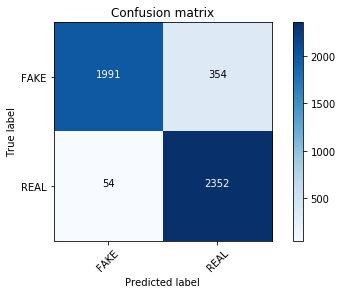

In [34]:
clf.fit(bin_tfidf_train, bin_y_train)
pred = clf.predict(bin_tfidf_train)
score = metrics.accuracy_score(bin_y_train, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(bin_y_train, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.872
Confusion matrix, without normalization


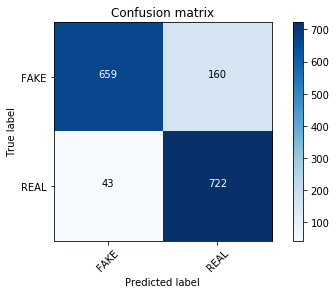

In [35]:
clf.fit(bin_tfidf_train, bin_y_train)
pred = clf.predict(bin_tfidf_test)
score = metrics.accuracy_score(bin_y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(bin_y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

## Configuration 2
* model b - train - [performance measures]
* model b - validation - [performance measures]
* model b - test - [performance measures]

In [53]:
clf = MultinomialNB()

accuracy:   0.602
Confusion matrix, without normalization


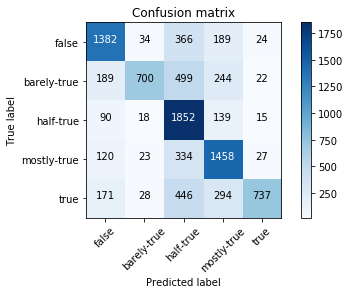

In [58]:
clf.fit(mul_tfidf_train, mul_y_train)
pred = clf.predict(mul_tfidf_train)

#print(pred[:20])

score = metrics.accuracy_score(mul_y_train, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(mul_y_train, pred, labels=['false', 'barely-true' , 'half-true' , 'mostly-true' , 'true'])
plot_confusion_matrix(cm, classes=['false', 'barely-true' , 'half-true' , 'mostly-true' , 'true'])

In [59]:
clf = MultinomialNB()

accuracy:   0.238
Confusion matrix, without normalization


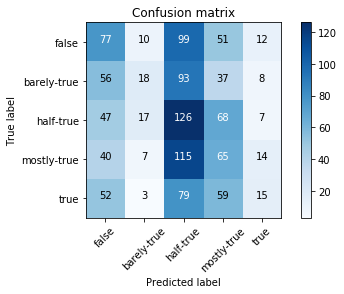

In [60]:
clf.fit(mul_tfidf_train, mul_y_train)
pred = clf.predict(mul_tfidf_test)
score = metrics.accuracy_score(mul_y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(mul_y_test, pred, labels=['false', 'barely-true' , 'half-true' , 'mostly-true' , 'true'])
plot_confusion_matrix(cm, classes=['false', 'barely-true' , 'half-true' , 'mostly-true' , 'true'])

In [ ]:
clf = MultinomialNB()

accuracy:   0.231
Confusion matrix, without normalization


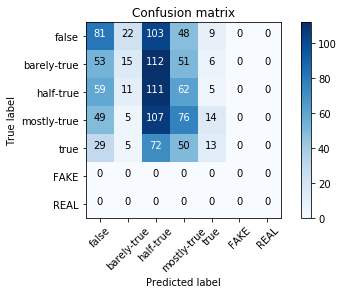

In [76]:
clf.fit(mul_tfidf_train, mul_y_train)
pred = clf.predict(mul_tfidf_valid)
score = metrics.accuracy_score(mul_y_valid, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(mul_y_valid, pred, labels=['false', 'barely-true' , 'half-true' , 'mostly-true' , 'true'])
plot_confusion_matrix(cm, classes=['false', 'barely-true' , 'half-true' , 'mostly-true' , 'true'])

## Configuration 3 (!no train)
* model a - test - dataset2 - [performance measures]
* model b - test - dataset1 - [performance measures]

In [65]:
clf = MultinomialNB()

In [73]:
#print(type(bin_tfidf_train),type(mul_tfidf_test))

tmp_mul_tfidf_test = bin_tfidf_vectorizer.transform(mul_X_test)

print(mul_y_test[:5])

0            true
1           false
2           false
3       half-true
4      pants-fire
5            true
6            true
7     barely-true
8            true
9     barely-true
10    barely-true
11    barely-true
12     pants-fire
13          false
14      half-true
15           true
16     pants-fire
17      half-true
18           true
19          false
20    mostly-true
21      half-true
22     pants-fire
23    mostly-true
24          false
25           true
26    barely-true
27      half-true
28           true
29    mostly-true
Name: y, dtype: object


In [96]:
clf.fit(bin_tfidf_train, bin_y_train)
pred = clf.predict(tmp_mul_tfidf_test)

In [97]:
print(len(pred))
pred = np.array(pred, dtype=object)

pred[pred == "FAKE"] = "false"
pred[pred == "REAL"] = "true"

print(pred[:30])
#pred[pred['FAKE']==false]

1267
['true' 'true' 'true' 'true' 'true' 'true' 'true' 'true' 'true' 'true'
 'true' 'true' 'true' 'true' 'true' 'true' 'false' 'true' 'true' 'true'
 'true' 'true' 'true' 'false' 'false' 'true' 'false' 'true' 'true' 'false']


accuracy:   0.169
Confusion matrix, without normalization


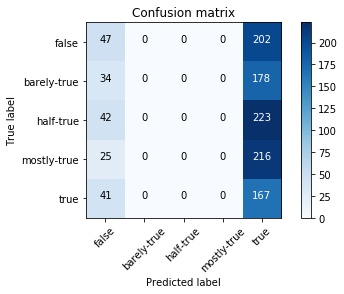

In [99]:
score = metrics.accuracy_score(mul_y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(mul_y_test, pred, labels=['false', 'barely-true' , 'half-true' , 'mostly-true' , 'true' ])
plot_confusion_matrix(cm, classes=['false', 'barely-true' , 'half-true' , 'mostly-true' , 'true'])

In [119]:
clf = MultinomialNB()
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier()

In [ ]:
tmp_bin_tfidf_test = mul_tfidf_vectorizer.transform(bin_X_test)

print(mul_y_test[:10])

0           true
1          false
2          false
3      half-true
4     pants-fire
5           true
6           true
7    barely-true
8           true
9    barely-true
Name: y, dtype: object


In [ ]:
clf.fit(mul_tfidf_train, mul_y_train)
pred = clf.predict(tmp_bin_tfidf_test)

In [ ]:
print(pred[:20])

bin_y_test = np.array(bin_y_test, dtype=object)

bin_y_test[bin_y_test == "FAKE"] = "false"
bin_y_test[bin_y_test == "REAL"] = "true"

In [ ]:
score = metrics.accuracy_score(bin_y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(bin_y_test, pred, labels=['false', 'barely-true' , 'half-true' , 'mostly-true' , 'true'])
plot_confusion_matrix(cm, classes=['false', 'barely-true' , 'half-true' , 'mostly-true' , 'true'])

## Configuration 4
* model c - train - [performance measures][0:4]
* model c - test - [performance measures][0:4]